<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

In [10]:
!jt -t gruvboxd

# Classification with LSTM

* LSTM에는 sequential data가 필요하며, 이를 활용하는 것은 매우 귀찮은 일임(많은 전처리 필요)
    1. 단어를 가지고 dict를 만들고,
    2. dict를 가지고 one-hot vector를 만들고,
    3. Word2Vec 등을 통해 Embedding을 만들고,
    4. 이 embedding된 vector를 사용해야함

* 그래서, 이번 강의에서는 그냥 MNIST를 사용할 예정
    * 28 * 28의 데이터를, 28개의 행 데이터가 28번 있는 sequential data로 가정
    * 마지막에 하나의 NN을 거쳐 분류가 될 수 있도록

* 옛날 TensorFlow에서는 RNN을 사용하는 것이 매우 힘든 일이었음
    * 버전이 바뀌면서 문법이 계속 바뀌었기 때문
    * PyTorch는 상당히 편함

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.13.1].
device:[cuda:0].


### Dataset and Loader

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [3]:
class RecurrentNeuralNetworkClass(nn.Module):
    def __init__(self, name='rnn', xdim=28, hdim=256, ydim=10, n_layer=3):
        super(RecurrentNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.n_layer = n_layer # The number of layers. Output 나오면 stack -> 반복

        self.rnn = nn.LSTM(
            # batch_first: LSTM의 output이 어떻게 나올지(False로 하면 semantic error가 발생함)
            input_size=self.xdim, hidden_size=self.hdim, num_layers=self.n_layer, batch_first=True)
        # 추가되는 linear layer
        self.lin = nn.Linear(self.hdim,self.ydim)

    def forward(self,x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(
            # FILL IN HERE
            self.n_layer, x.size(0), self.hdim
        ).to(device)
        c0 = torch.zeros(
            # FILL IN HERE
            self.n_layer, x.size(0), self.hdim
        ).to(device)
        # RNN
        rnn_out, (hn, cn) = self.rnn(x, (h0, c0)) 
        # x:[N x L x Q] => rnn_out:[N x L x D]
        # Linear
        out = self.lin(
            # FILL IN HERE
            rnn_out[:, -1:]
           ).view([-1, self.ydim]) 
        return out 

R = RecurrentNeuralNetworkClass(
    name='rnn', xdim=28, hdim=256, ydim=10, n_layer=2).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(R.parameters(), lr=1e-3)
print ("Done.")

Done.


### Check How LSTM Works
- `N`: number of batches
- `L`: sequence lengh
- `Q`: input dim
- `K`: number of layers
- `D`: LSTM feature dimension

` Y,(hn,cn) = LSTM(X) `

- `X`: [N x L x Q] - `N` input sequnce of length `L` with `Q` dim. 
- `Y`: [N x L x D] - `N` output sequnce of length `L` with `D` feature dim.
- `hn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` feature dim. 
- `cn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` cell dim. 

In [9]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2, 10, 28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
rnn_out, (hn, cn) = R.rnn(x_torch) # forward path

print ("rnn_out:", rnn_out.shape) # [N x L x D]
print ("Hidden State hn:", hn.shape) # [K x N x D]
print ("Cell States cn:", cn.shape) # [K x N x D]

rnn_out: torch.Size([2, 10, 256])
Hidden State hn: torch.Size([2, 2, 256])
Cell States cn: torch.Size([2, 2, 256])


### Check parameters

In [7]:
# Parameter가 82만 개임
# LSTM 내부에 들어가는 네 개 layer가 기본적으로 dense layer임 -> 2 * (hidden dim)**2
# 즉, LSTM의 parameter를 줄이기 위해서는, hidden dimension 자체를 줄여야 함
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(R.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[rnn.weight_ih_l0] shape:[(1024, 28)].
    val:[ 0.043 -0.019 -0.011  0.01   0.013]
[1] name:[rnn.weight_hh_l0] shape:[(1024, 256)].
    val:[-0.001  0.06  -0.039 -0.051  0.033]
[2] name:[rnn.bias_ih_l0] shape:[(1024,)].
    val:[ 0.011  0.001  0.021 -0.036 -0.009]
[3] name:[rnn.bias_hh_l0] shape:[(1024,)].
    val:[ 0.052 -0.001  0.06  -0.012 -0.045]
[4] name:[rnn.weight_ih_l1] shape:[(1024, 256)].
    val:[ 0.002 -0.003 -0.028 -0.038  0.012]
[5] name:[rnn.weight_hh_l1] shape:[(1024, 256)].
    val:[ 0.053 -0.029  0.054  0.03   0.052]
[6] name:[rnn.bias_ih_l1] shape:[(1024,)].
    val:[ 0.001  0.058 -0.017  0.025 -0.033]
[7] name:[rnn.bias_hh_l1] shape:[(1024,)].
    val:[-0.034  0.06   0.01   0.032 -0.   ]
[8] name:[lin.weight] shape:[(10, 256)].
    val:[-0.028  0.027  0.043  0.026  0.057]
[9] name:[lin.bias] shape:[(10,)].
    val:[-0.017  0.022  0.001  0.023  0.015]
Total number of parameters:[821,770].


### Simple Forward Path 

In [8]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(3, 10, 28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = R.forward(x_torch) # [N x 1 x R] where R is the output dim.
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
# print ("x_torch:\n", x_torch)
# print ("y_torch:\n", y_torch)
print ("x_numpy %s"%(x_numpy.shape,))
print ("y_numpy %s"%(y_numpy.shape,))

x_numpy (3, 10, 28)
y_numpy (3, 10)


### Evaluation Function

In [10]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.view(-1, 28, 28).to(device))
            _,y_pred = torch.max(model_pred, 1)
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct / n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [11]:
train_accr = func_eval(R, train_iter, device)
test_accr = func_eval(R, test_iter, device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr, test_accr))

train_accr:[0.099] test_accr:[0.096].


### Train

In [13]:
print ("Start training.")
R.train() # to train mode 
EPOCHS, print_every = 10, 1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter:
        # Forward path
        y_pred = R.forward(batch_in.view(-1, 28, 28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum / len(train_iter)
    # Print
    if ((epoch % print_every) == 0) or (epoch == (EPOCHS - 1)):
        train_accr = func_eval(R, train_iter, device)
        test_accr = func_eval(R, test_iter, device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch, loss_val_avg, train_accr, test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.042] train_accr:[0.987] test_accr:[0.983].
epoch:[1] loss:[0.035] train_accr:[0.992] test_accr:[0.986].
epoch:[2] loss:[0.031] train_accr:[0.987] test_accr:[0.980].
epoch:[3] loss:[0.026] train_accr:[0.989] test_accr:[0.984].
epoch:[4] loss:[0.024] train_accr:[0.994] test_accr:[0.988].
epoch:[5] loss:[0.019] train_accr:[0.995] test_accr:[0.989].
epoch:[6] loss:[0.025] train_accr:[0.994] test_accr:[0.989].
epoch:[7] loss:[0.019] train_accr:[0.995] test_accr:[0.988].
epoch:[8] loss:[0.020] train_accr:[0.995] test_accr:[0.988].
epoch:[9] loss:[0.015] train_accr:[0.997] test_accr:[0.989].
Done


### Test

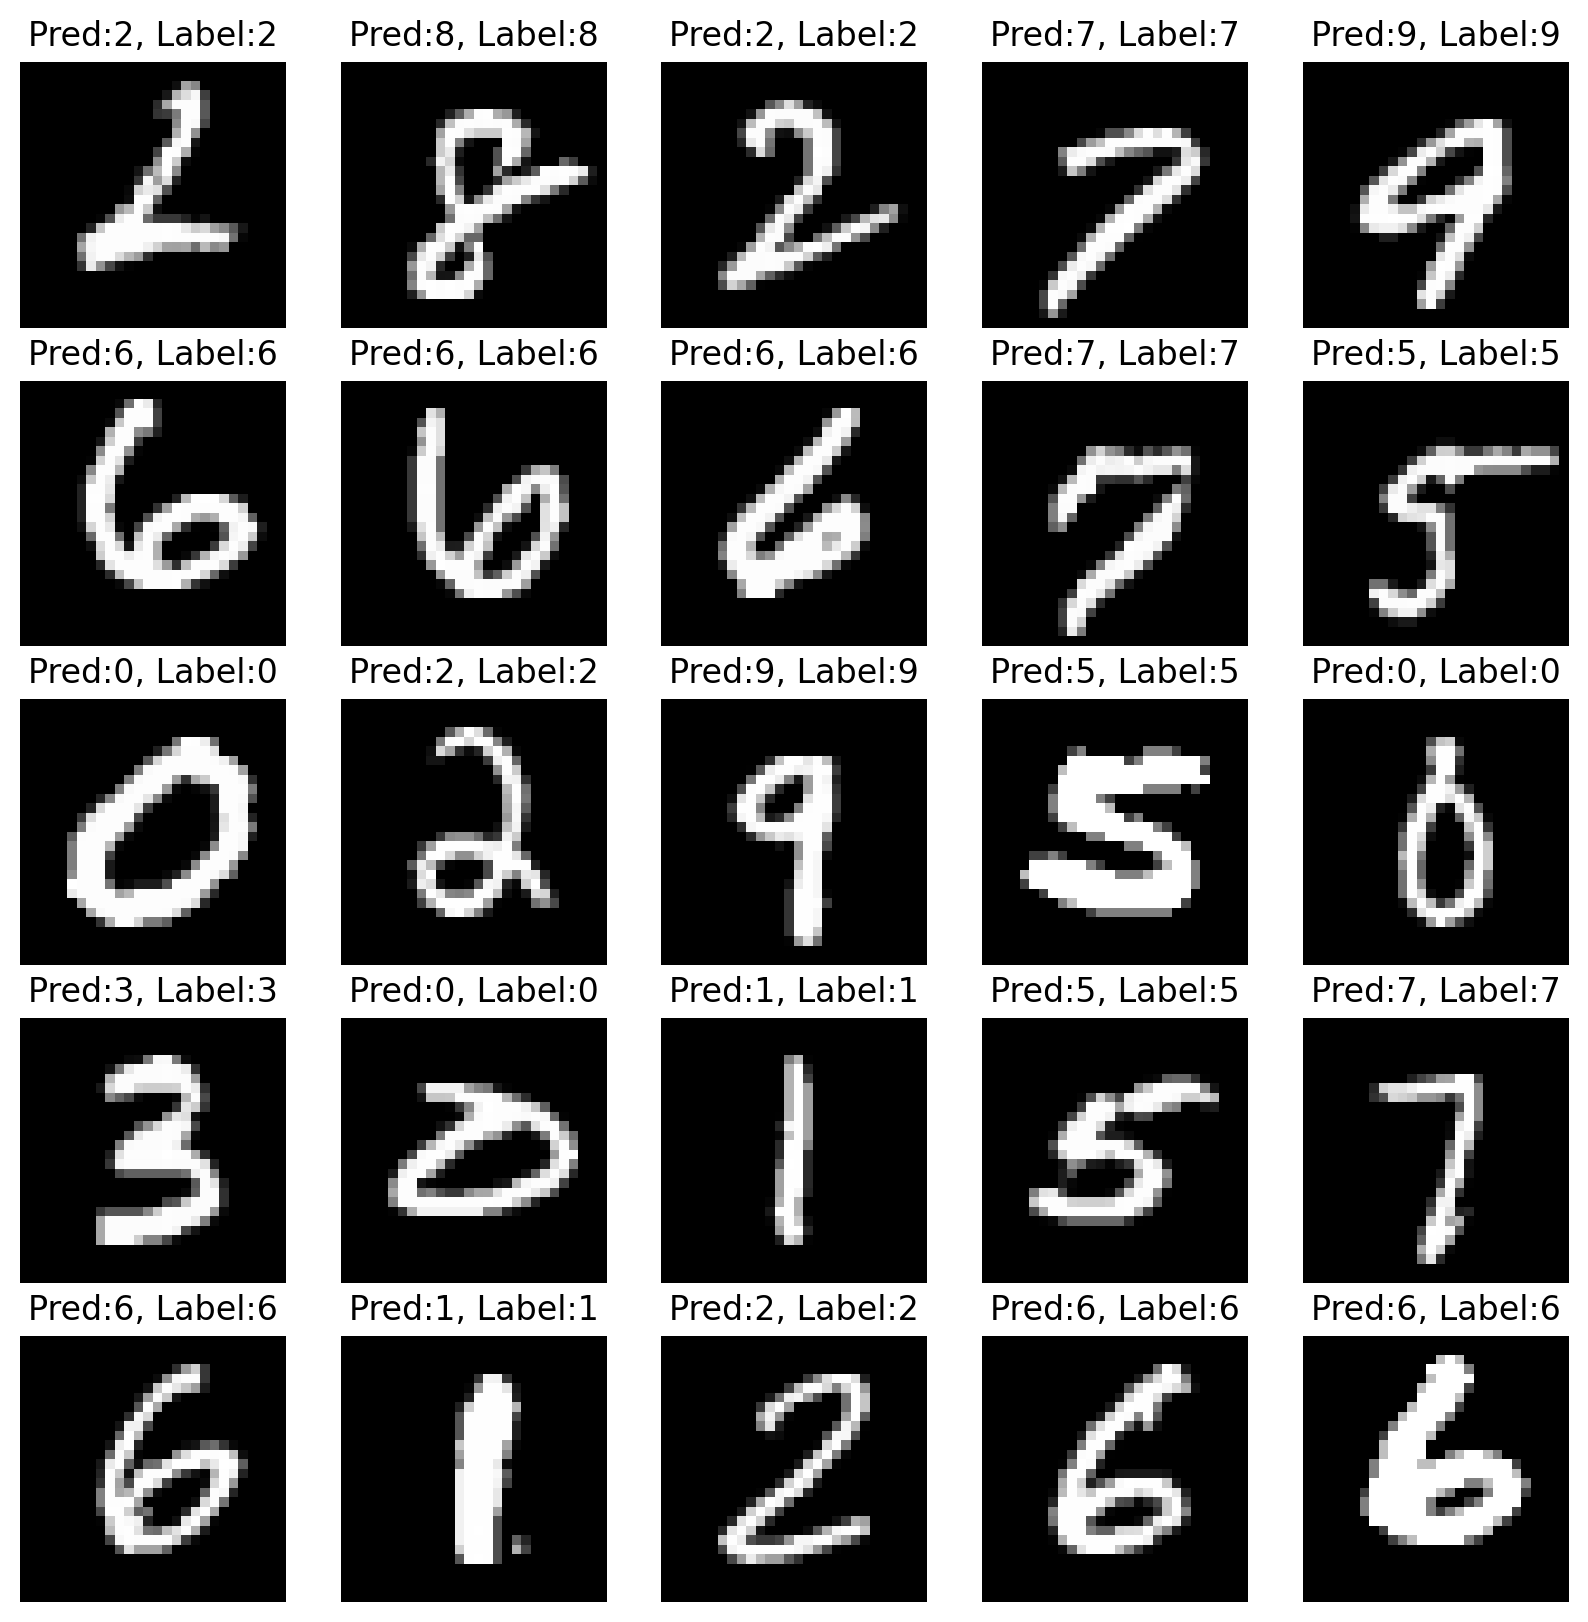

Done


In [14]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    R.eval() # to evaluation mode 
    y_pred = R.forward(test_x.view(-1, 28, 28).type(torch.float).to(device) / 255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10, 10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx], test_y[idx]))
plt.show()
print ("Done")

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

